### Kaggle - Airbnb Dataset
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings

This notebook tries to predict in which countery the airbnb's new users will make his or her bookings. This notebook is an analysis of various classifiers with all the features and only the top important features

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [2]:
def normalize_df(dataframe):
    for field in dataframe:
        df_column = dataframe[field].values.reshape(-1, 1)
        min_max_scaler = preprocessing.MinMaxScaler()
        np_scaled = min_max_scaler.fit_transform(df_column)
        dataframe[field] = pd.DataFrame(np_scaled)
    return dataframe

def score_report(predicted_value, actual_value):
    print("*"*100)
    print("Confusion Matrix ::\n{}".format(confusion_matrix(predicted_value, actual_value)))
    acc_score = accuracy_score(predicted_value, actual_value)
    print("\nAccuracy Score ::\n{}".format(acc_score))
    prec_score = precision_score(predicted_value, actual_value, average='macro')
    print("\nPrecision Score ::\n{}".format(prec_score))
    rec_score = recall_score(predicted_value, actual_value, average='macro')
    print("\nRecall Score ::\n{}".format(rec_score))
    f1_scre = f1_score(predicted_value, actual_value, average='macro')
    print("\nF1 Score ::\n{}".format(f1_scre))
    print("\nClassification Report ::\n{}".format(classification_report(predicted_value, actual_value)))    
    print("*"*100)
    return acc_score, prec_score, rec_score, f1_scre

In [3]:
with open('data/train_users_2.csv', 'rb') as file_:
    train_df = pd.read_csv(file_)

In [4]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,bjjt8pjhuk,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,87mebub9p4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


In [5]:
train_df['date_account_created'] = pd.to_datetime(train_df['date_account_created'])
train_df['date_first_booking'] = pd.to_datetime(train_df['date_first_booking'])

Visualizing the data can give us better hind sight

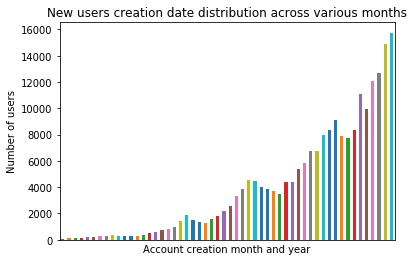

In [6]:
train_df.groupby([train_df['date_account_created'].dt.year, train_df['date_account_created'].dt.month]) \
            ['id'].count().plot(kind='bar')
plt.xlabel("Account creation month and year")
plt.xticks([])
plt.ylabel("Number of users")
plt.title("New users creation date distribution across various months")
plt.show()

We need to remove the error data. Lets just make the errors as nan.

In [7]:
train_df[train_df.age<10] = np.nan
train_df[train_df.age>100] = np.nan

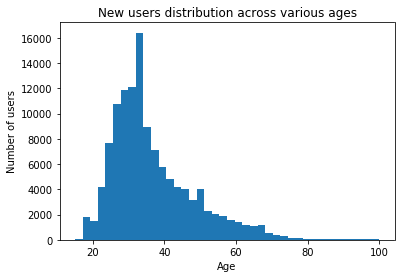

In [8]:
train_df.age.plot(kind='hist', bins=40)
plt.xlabel("Age")
plt.ylabel("Number of users")
plt.title("New users distribution across various ages")
plt.show()

As we can see most of the user's are between the age 25 and 40. It will be useful to consider this as a seperate feature

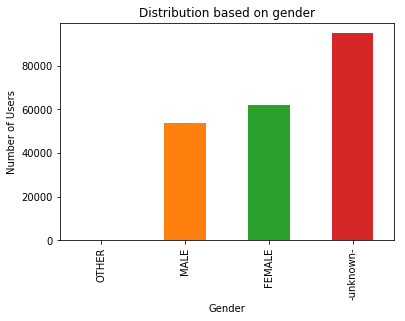

gender
OTHER          279
MALE         53732
FEMALE       62069
-unknown-    94969
Name: id, dtype: int64

In [9]:
train_df.groupby('gender')['id'].count().sort_values().plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Number of Users')
plt.title('Distribution based on gender')
plt.show()

train_df.groupby('gender')['id'].count().sort_values()

Our train data is very much skewed towards a single category. Inorder to overcome this we can do weighted sampling. But for simplicity and to understand the concepts I'm doing normal train-test split

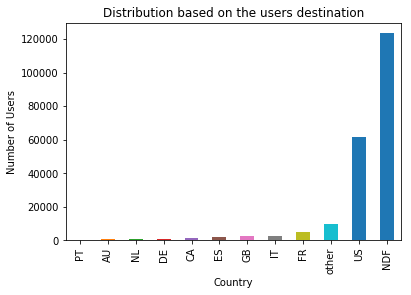

In [10]:
train_df.groupby('country_destination')['id'].count().sort_values().plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('Distribution based on the users destination')
plt.show()

One way to encode dates.

In [11]:
train_df['date_account_created_day'] = train_df['date_account_created'].dt.day
train_df['date_account_created_month'] = train_df['date_account_created'].dt.month
train_df['date_account_created_year'] = train_df['date_account_created'].dt.year

train_df['date_first_booking_day'] = train_df['date_first_booking'].dt.day
train_df['date_first_booking_month'] = train_df['date_first_booking'].dt.month
train_df['date_first_booking_year'] = train_df['date_first_booking'].dt.year

In [12]:
train_df['age_25_to_40'] = ((train_df.age > 25) & (train_df.age < 40)).map({True:1, False:0})
train_df['age_less_than_25'] = (train_df.age < 25).map({True:1, False:0})
train_df['age_more_than_40'] = (train_df.age > 40).map({True:1, False:0})
train_df['age_is_nan'] = (train_df.age.isnull()).map({True:1, False:0})

In [13]:
train_df['gender_unknown_or_other'] = ((train_df.gender == '-unknown-') | (train_df.gender == 'OTHER')).map({True:1, False:0})

In [14]:
train_df.head()

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,...,date_account_created_month,date_account_created_year,date_first_booking_day,date_first_booking_month,date_first_booking_year,age_25_to_40,age_less_than_25,age_more_than_40,age_is_nan,gender_unknown_or_other
0,gxn3p5htnn,2010-06-28,2.009032e+13,NaT,-unknown-,NaN,facebook,0.0,en,direct,...,6.0,2010.0,NaN,NaN,NaN,0,0,0,1,1
1,820tgsjxq7,2011-05-25,2.009052e+13,NaT,MALE,38.0,facebook,0.0,en,seo,...,5.0,2011.0,NaN,NaN,NaN,1,0,0,0,0
2,4ft3gnwmtx,2010-09-28,2.009061e+13,2010-08-02,FEMALE,56.0,basic,3.0,en,direct,...,9.0,2010.0,2.0,8.0,2010.0,0,0,1,0,0
3,bjjt8pjhuk,2011-12-05,2.009103e+13,2012-09-08,FEMALE,42.0,facebook,0.0,en,direct,...,12.0,2011.0,8.0,9.0,2012.0,0,0,1,0,0
4,87mebub9p4,2010-09-14,2.009121e+13,2010-02-18,-unknown-,41.0,basic,0.0,en,direct,...,9.0,2010.0,18.0,2.0,2010.0,0,0,1,0,1


Do one-hot encoding on the categorical variables.

In [15]:
one_hot_columns = ['gender', 'signup_method', 'language', 'affiliate_channel', 'affiliate_provider', \
                   'first_affiliate_tracked', 'signup_app', 'first_device_type', 'first_browser']
encoding = pd.get_dummies(train_df[one_hot_columns], columns=one_hot_columns, prefix=one_hot_columns)

Normalizing the data between 0 and 1.

In [16]:
normalize_columns = ['age', 'date_account_created_day', 'date_account_created_month', 'date_account_created_year', \
                    'date_first_booking_day', 'date_first_booking_month', 'date_first_booking_year', 'signup_flow']
train_df[normalize_columns] = train_df[normalize_columns].fillna(0).astype(int)
train_df[normalize_columns] = normalize_df(train_df[normalize_columns])

c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int32 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [17]:
encoded_df = pd.concat([train_df['id'], train_df[normalize_columns], encoding], axis=1)

In [18]:
X = encoded_df.drop('id', axis=1)
y = train_df['country_destination'].fillna('other')

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [20]:
clf = RandomForestClassifier()

clf.fit(X=X_train, y=y_train)
preds = clf.predict(X_test)

all_features_acc_score, all_features_prec_score, all_features_rec_score, all_features_f1_score = score_report(preds, y_test)

****************************************************************************************************
Confusion Matrix ::
[[    0     1     2     0     2     1     0     0     0     0    16     4]
 [    1     0     0     1     6     5     2     0     0     0    43     7]
 [    0     3     2     0     0     2     0     0     0     0    23     8]
 [    0     3     1     3     9     3     5     0     5     0    59    11]
 [    2     3     2     6    20     8    10     0     2     1   184    35]
 [    2     1     2     2     6     1     3     0     1     2    61    14]
 [    0     0     2     7     8     2     6     0     1     1    87    17]
 [    0     0     0     0     0     0     0 24667     0     0     0     0]
 [    0     1     0     1     0     1     0     0     0     0    21     1]
 [    0     0     0     0     0     1     0     0     0     0     7     0]
 [  103   267   195   382   925   394   529     0   146    44 11427  1862]
 [    4    10     3    21    23     9    13     0     

In [21]:
feature_importances = pd.DataFrame(clf.feature_importances_, index = X_train.columns, columns=['importance'])\
                    .sort_values('importance', ascending=False)
print("Top 20 features :\n{}".format(feature_importances[:20]))
top_features = feature_importances.index.tolist()

Top 20 features :
                                   importance
date_first_booking_day               0.360504
date_first_booking_month             0.242908
date_first_booking_year              0.107576
date_account_created_day             0.066166
age                                  0.054233
date_account_created_month           0.041020
date_account_created_year            0.014215
gender_FEMALE                        0.009133
gender_-unknown-                     0.008420
signup_flow                          0.007187
gender_MALE                          0.005915
language_en                          0.005666
signup_method_basic                  0.005535
first_affiliate_tracked_untracked    0.004669
first_browser_Chrome                 0.004391
first_affiliate_tracked_linked       0.004293
first_browser_Firefox                0.004290
signup_method_facebook               0.004223
first_device_type_Mac Desktop        0.003713
first_device_type_Windows Desktop    0.003536


In [22]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
all_nb_acc_score, all_nb_prec_score, all_nb_rec_score, all_nb_f1_score = score_report(preds, y_test)

****************************************************************************************************
Confusion Matrix ::
[[    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     1     1]
 [    0     0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     0     0     0     0     0     0     0     0     1     1]
 [    0     0     0     0     1     0     0     0     0     0     2     2]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     0     0     0     0     3     0]
 [    0     0     0     0     0     0     0 24667     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     4     0]
 [  112   289   209   421   994   427   567     0   162    48 12218  2017]
 [    0     0     0     1     4     0     1     0     

c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 Score ::
0.1794954365187075

Classification Report ::
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00         0
         CA       0.00      0.00      0.00         2
         DE       0.00      0.00      0.00         2
         ES       0.00      0.00      0.00         2
         FR       0.00      0.20      0.00         5
         GB       0.00      0.00      0.00         0
         IT       0.00      0.00      0.00         4
        NDF       1.00      1.00      1.00     24667
         NL       0.00      0.00      0.00         0
         PT       0.00      0.00      0.00         4
         US       1.00      0.70      0.82     17464
      other       0.20      0.94      0.33       541

avg / total       0.99      0.88      0.92     42691

****************************************************************************************************


c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [23]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
all_nn_acc_score, all_nn_prec_score, all_nn_rec_score, all_nn_f1_score = score_report(preds, y_test)

****************************************************************************************************
Confusion Matrix ::
[[    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0     0     2     0     0     0     0     0     6     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     0     0     0     0     3     1]
 [    0     0     0     0     0     0     0 24667     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     2]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [  112   287   208   422   996   426   567     0   162    48 12216  2023]
 [    0     2     1     0     1     1     1     0     

c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



Recall Score ::
0.239906253205311

F1 Score ::
0.17938845588091976

Classification Report ::
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00         0
         CA       0.00      0.00      0.00         0
         DE       0.00      0.00      0.00         2
         ES       0.00      0.00      0.00         1
         FR       0.00      0.25      0.00         8
         GB       0.00      0.00      0.00         0
         IT       0.00      0.00      0.00         5
        NDF       1.00      1.00      1.00     24667
         NL       0.00      0.00      0.00         2
         PT       0.00      0.00      0.00         0
         US       1.00      0.70      0.82     17467
      other       0.20      0.93      0.33       539

avg / total       0.99      0.88      0.92     42691

****************************************************************************************************


c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


We can filter out the features that have less importance.

In [24]:
print(feature_importances[feature_importances['importance'] > 0.0001].count())

importance    68
dtype: int64


Take the top 70 features and do train-test split

In [25]:
#oly the top 70 features
X_train, X_test, y_train, y_test = train_test_split(X[top_features[:70]], y, test_size=0.2)

In [26]:
X_train.head()

,date_first_booking_day,date_first_booking_month,date_first_booking_year,date_account_created_day,age,date_account_created_month,date_account_created_year,gender_FEMALE,gender_-unknown-,signup_flow,...,language_it,language_ru,affiliate_provider_yahoo,language_pt,affiliate_provider_facebook-open-graph,language_ja,language_nl,first_browser_Opera,language_sv,affiliate_provider_padmapper
77700,0.709677,0.416667,0.999007,0.548387,0.43,0.416667,0.999503,1,0,0.0,...,0,0,0,0,0,0,0,0,0,0
170826,0.064516,0.500000,0.999504,0.064516,0.35,0.333333,1.000000,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
161960,0.000000,0.000000,0.000000,0.354839,0.00,0.250000,1.000000,0,1,1.0,...,0,0,0,0,0,0,0,0,0,0
49199,0.000000,0.000000,0.000000,0.612903,0.35,0.916667,0.999007,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
126441,0.451613,0.083333,0.999504,0.677419,0.60,0.916667,0.999503,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [27]:
clf = RandomForestClassifier()
clf.fit(X=X_train, y=y_train)
preds = clf.predict(X_test)
rf_acc_score, rf_prec_score, rf_rec_score, rf_f1_score = score_report(preds, y_test)

****************************************************************************************************
Confusion Matrix ::
[[    0     0     0     0     0     2     0     0     0     0     6     3]
 [    0     0     0     2     8     4     0     0     0     0    40     3]
 [    0     3     0     0     1     0     0     0     0     0    18     6]
 [    0     0     1     5     3     1     4     0     2     0    62     7]
 [    2     5     6    11    27     8    11     0     5     0   198    20]
 [    0     3     3     4     5     5     3     0     2     2    70    16]
 [    1     4     2     3    11     4     4     0     0     1    82    20]
 [    0     0     0     0     0     0     0 24722     0     0     0     0]
 [    0     1     0     0     1     0     1     0     0     1    22     1]
 [    0     0     0     0     1     0     1     0     0     0     6     0]
 [  110   235   200   401   895   382   527     0   128    46 11436  1855]
 [    4     9     5    12    29    16    21     0     

In [28]:
clf = BernoulliNB()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
nb_acc_score, nb_prec_score, nb_rec_score, nb_f1_score = score_report(preds, y_test)

****************************************************************************************************
Confusion Matrix ::
[[    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     1     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     2     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     1     0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0 24722     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [  117   260   217   436   979   422   568     0   140    53 12236  1979]
 [    0     0     0     1     2     0     3     0     

c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 Score ::
0.18113023817895887

Classification Report ::
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00         0
         CA       0.00      0.00      0.00         0
         DE       0.00      0.00      0.00         2
         ES       0.00      0.00      0.00         0
         FR       0.00      0.00      0.00         2
         GB       0.00      0.00      0.00         0
         IT       0.00      0.00      0.00         2
        NDF       1.00      1.00      1.00     24722
         NL       0.00      0.00      0.00         0
         PT       0.00      0.00      0.00         0
         US       1.00      0.70      0.83     17407
      other       0.21      0.96      0.35       556

avg / total       0.99      0.88      0.92     42691

****************************************************************************************************


c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [29]:
clf = MLPClassifier()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
nn_acc_score, nn_prec_score, nn_rec_score, nn_f1_score = score_report(preds, y_test)

****************************************************************************************************
Confusion Matrix ::
[[    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     0     0]
 [    0     0     0     0     1     0     0     0     0     0     2     1]
 [    0     0     0     0     0     0     0     0     0     0     1     0]
 [    0     0     0     2     1     0     3     0     0     0     5     0]
 [    0     0     0     0     0     0     0 24722     0     0     0     0]
 [    0     0     0     0     0     0     0     0     1     0     0     0]
 [    0     0     0     0     0     0     0     0     0     0     0     0]
 [  117   260   217   432   973   422   567     0   139    53 12217  1979]
 [    0     0     0     4     5     0     2     0     

c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)



F1 Score ::
0.18308089444249806

Classification Report ::
             precision    recall  f1-score   support

         AU       0.00      0.00      0.00         0
         CA       0.00      0.00      0.00         1
         DE       0.00      0.00      0.00         0
         ES       0.00      0.00      0.00         1
         FR       0.00      0.25      0.00         4
         GB       0.00      0.00      0.00         1
         IT       0.01      0.27      0.01        11
        NDF       1.00      1.00      1.00     24722
         NL       0.01      1.00      0.01         1
         PT       0.00      0.00      0.00         0
         US       1.00      0.70      0.82     17376
      other       0.21      0.93      0.35       574

avg / total       0.99      0.88      0.92     42691

****************************************************************************************************


c:\users\rajsu\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [30]:
I = pd.Index(['All features random forest', 'All features naive bayes', 'All features neural network', \
              'Top features random forest', 'Top features naive bayes', 'Top features neural network'], name='rows')
C = pd.Index(['Accuracy', 'Precision', 'Recall', 'F1'], name='columns')

score_matrix = pd.DataFrame(data=[[all_features_acc_score, all_features_prec_score, all_features_rec_score, all_features_f1_score], \
                       [all_nb_acc_score, all_nb_prec_score, all_nb_rec_score, all_nb_f1_score], \
                       [all_nn_acc_score, all_nn_prec_score, all_nn_rec_score, all_nn_f1_score], \
                       [rf_acc_score, rf_prec_score, rf_rec_score, rf_f1_score], \
                       [nb_acc_score, nb_prec_score, nb_rec_score, nb_f1_score], \
                       [nn_acc_score, nn_prec_score, nn_rec_score, nn_f1_score]], index=I, columns=C)

Summary of the classifiers performance.

In [31]:
score_matrix

columns,Accuracy,Precision,Recall,F1
rows,,,,
All features random forest,0.859525,0.183868,0.207369,0.183673
All features naive bayes,0.875875,0.183151,0.236243,0.179495
All features neural network,0.875735,0.183056,0.239906,0.179388
Top features random forest,0.861587,0.185238,0.209483,0.185562
Top features naive bayes,0.878241,0.184271,0.222097,0.181130
Top features neural network,0.877890,0.185226,0.346345,0.183081
